In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

In [3]:
raw_data = pd.read_csv("../data/cars.csv")
raw_data

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4
...,...,...,...,...,...,...,...,...,...
4340,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,S 350
4341,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,535
4342,BMW,8000.0,sedan,194,2.0,Petrol,yes,1985,520
4343,Toyota,14200.0,sedan,31,NaN,Petrol,yes,2014,Corolla


Pré processamento

In [4]:
raw_data.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


Determinando as variáveis de interesse

In [5]:
data = raw_data.drop(["Model"], axis=1)

In [6]:
data.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [7]:
data_no_mv = data.dropna(axis=0)

In [8]:
data_no_mv

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011
...,...,...,...,...,...,...,...,...
4339,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014
4340,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014
4341,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999
4342,BMW,8000.0,sedan,194,2.0,Petrol,yes,1985


/tmp/ipykernel_405598/2991907454.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_no_mv["Price"])


<Axes: xlabel='Price', ylabel='Density'>

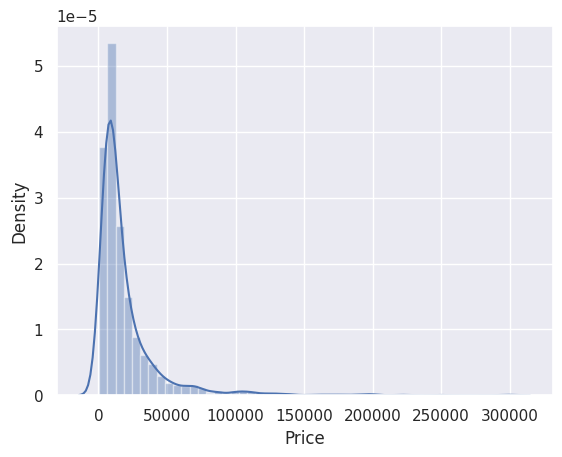

In [12]:
sns.distplot(data_no_mv["Price"])

In [13]:
q = data_no_mv["Price"].quantile(0.99)
data_1 = data_no_mv[data_no_mv["Price"] < q]
data_1.describe(include="all")

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


<Axes: ylabel='Price'>

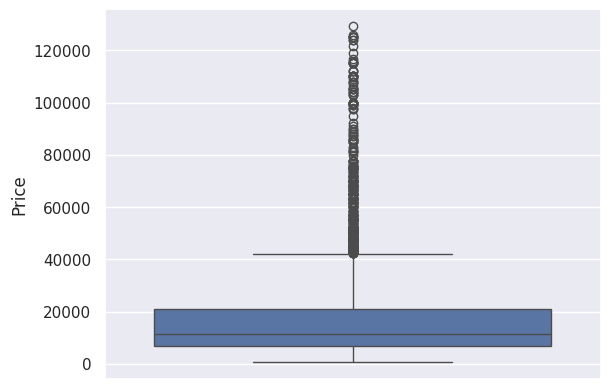

In [ ]:
sns.distplot(data_1["Price"])